In [4]:
import pandas as pd
import networkx as nx
import networkx.algorithms.community as nxcom
import matplotlib.pyplot as plt
import numpy as np

In [5]:
df_alpha = pd.read_csv('soc-sign-bitcoinalpha.csv',header=None)
df_alpha.rename(columns = {0:'SOURCE', 1:'TARGET',2:'RATING',3:'TIME'}, inplace = True)
df_alpha.head()

,SOURCE,TARGET,RATING,TIME
0,7188,1,10,1407470400
1,430,1,10,1376539200
2,3134,1,10,1369713600
3,3026,1,10,1350014400
4,3010,1,10,1347854400


In [205]:
df_alpha2 = pd.read_csv('soc-sign-bitcoinotc.csv',header=None)
df_alpha2.rename(columns = {0:'SOURCE', 1:'TARGET',2:'RATING',3:'TIME'}, inplace = True)
df_alpha2.head()
G_otc = nx.from_pandas_edgelist(df_alpha2, source='SOURCE', target='TARGET',edge_attr='RATING',create_using=nx.DiGraph())




## Forms of G

In [6]:
#visulization the dataset
G = nx.from_pandas_edgelist(df_alpha, source='SOURCE', target='TARGET',edge_attr='RATING',create_using=nx.DiGraph())

G_undirected = G.to_undirected()

for l in list(nx.strongly_connected_components(G)):
    if len(l)>10:
        G_strongly_connected = G.subgraph(l)
        break

G_sc_undirected = G_strongly_connected.to_undirected()
G_reverse = nx.reverse(G)

## Clustering Communities

In [7]:
# This function uses Clauset-Newman-Moore greedy modularity maximization to find the community partition with the largest modularity.
coms_gmc = list(nxcom.greedy_modularity_communities(G)) #cut off
# return a list of frozensets of nodes, one for each community. Sorted by length with largest communities first.

In [8]:
#  asynchronous fluid communities algorithm
coms_fluidc_25 = list(nxcom.asyn_fluidc(G_sc_undirected, k = 25)) # number
coms_fluidc_50 = list(nxcom.asyn_fluidc(G_sc_undirected, k = 50))
coms_fluidc_100 = list(nxcom.asyn_fluidc(G_sc_undirected, k = 100))
coms_fluidc_200 = list(nxcom.asyn_fluidc(G_sc_undirected, k = 200))
coms_fluidc = [coms_fluidc_25, coms_fluidc_50, coms_fluidc_100, coms_fluidc_200]
# return Iterable of communities given as sets of nodes.

In [9]:
# Finds communities in G using a semi-synchronous label propagation method
coms_lpc = list(nxcom.label_propagation_communities(G_undirected))
# return A dict_values object that contains a set of nodes for each community.

In [10]:

coms_k_clique_3 = list(nxcom.k_clique_communities(G_undirected, 3))
coms_k_clique_4 = list(nxcom.k_clique_communities(G_undirected, 4))
coms_k_clique_5 = list(nxcom.k_clique_communities(G_undirected, 5))
coms_k_clique_6 = list(nxcom.k_clique_communities(G_undirected, 6)) # min size
coms_k_clique = [coms_k_clique_3, coms_k_clique_4, coms_k_clique_5, coms_k_clique_6]

## Analysis

In [11]:
def cal_internal_weights(com):
    sub_G = G.subgraph(com)
    weights = 0
    ratings = nx.get_edge_attributes(sub_G, 'RATING')
    for edge in sub_G.edges():
        weights += ratings[edge]

    return weights, len(sub_G.edges())

def cal_external_weights(com):
    generator = nx.edge_boundary(G_reverse, com)
    weights = 0
    cnt = 0
    ratings = nx.get_edge_attributes(G_reverse, 'RATING')
    for edge in generator:
        weights += ratings[edge]
        cnt += 1
    return weights, cnt

In [188]:
def analyze_communities(coms, threshold=10, return_commons=False):
    iws, ics, ews, ecs = [],[],[],[] #internal, external
    iaws, eaws = [],[] # average
    diffs = [] # difference
    cheatings = []
    commons = []

    for com in coms:
        iw, ic = cal_internal_weights(com)
        ew, ec = cal_external_weights(com)
        if ec == 0 or ic == 0:
            continue
        iws.append(iw)
        ics.append(ic)
        ews.append(ew)
        ecs.append(ec)
        iaw = round(iw/ic, 2)
        eaw = round(ew/ec, 2)
        iaws.append(iaw)
        eaws.append(eaw)
        diffs.append(iaw - eaw)
        if iaw - eaw >= threshold:
            cheatings.append(com)
        else: commons.append(com)
    
    if not return_commons:
        return iaws, eaws, diffs, cheatings 
    else:
        return iaws, eaws, diffs, cheatings, commons


In [13]:
def analyze_difference(diffs):
    diffs = np.array(diffs)
    plt.hist(diffs)
    plt.show()

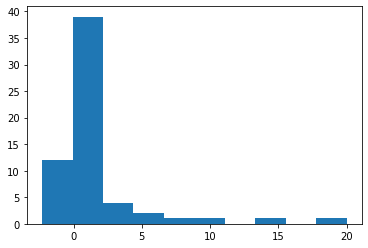

In [14]:
iaws, eaws, diffs, cheatings = analyze_communities(coms=coms_gmc)
analyze_difference(diffs)

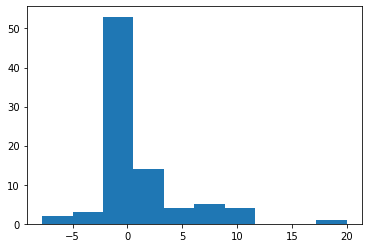

In [15]:
iaws, eaws, diffs, cheatings = analyze_communities(coms=coms_lpc)
analyze_difference(diffs)

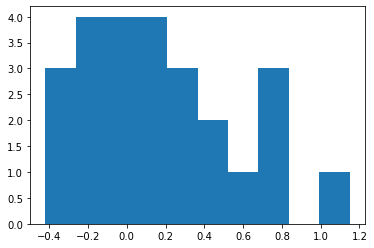

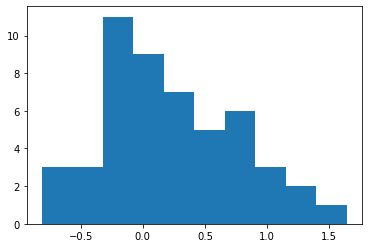

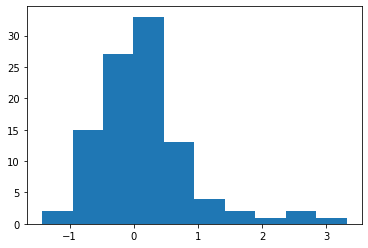

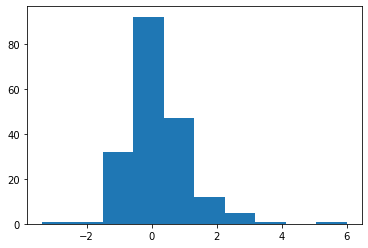

In [16]:
for coms in coms_fluidc:
    iaws, eaws, diffs, cheatings = analyze_communities(coms=coms)
    analyze_difference(diffs)

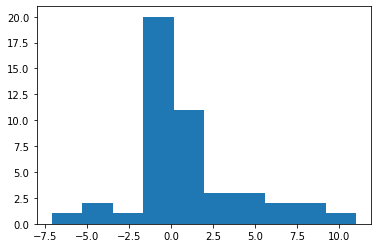

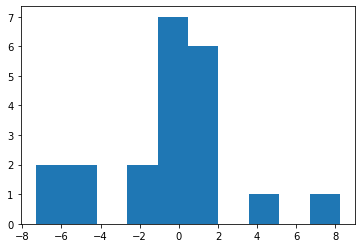

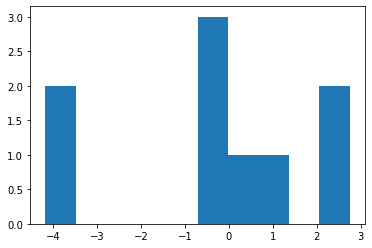

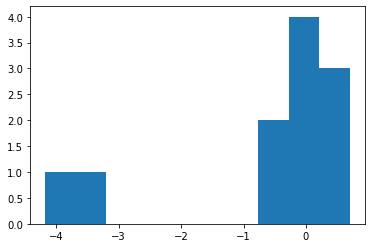

In [17]:
for coms in coms_k_clique:
    iaws, eaws, diffs, cheatings = analyze_communities(coms=coms)
    analyze_difference(diffs)

## Draw Pictures

画图

以10为界
Example cheating networks

**探究包含欺诈群体各类社群与good fair间关系**

good/fair 以gmn为例 直方图
good fair分布图 整个网络为整体 个体为单位 两个数据集 12
good fair 分布图 典型欺诈性社群/信任社群/其他社群为整体 社群内个体为单位 一个数据集 13
平均good fair 分布图 整个网络为整体 欺诈性社群/信任社群/其他社群 为单位 一个数据集 13

**探究社群划分数量与大小 与diffs的关系**
diffs 
algorithm, number, score difference, strong connected, multiple datasets, avg fog, community size

折线图
gmc，flu 横排 community number 纵向 diffs判定为cheating，信赖，普通的百分比 两个数据集 1 4

点云图
四种算法 横轴 community size 纵轴 diffs （可能平均fog）1 4 一个或两个数据集


画表

探究欺诈社群的判定与不同参数间的联系

大横轴 alpha otc
小横轴 四个算法
纵轴 
欺诈社群总体fair，以10  5为界
欺诈社群百分比，以10为界，5为界
欺诈社群强连通百分比 10 5


challenge 可能不被识别为社群


### Example cheatig networks

In [82]:
iaws, eaws, diffs, cheatings = analyze_communities(coms=coms_lpc, threshold=5)


In [96]:
example = cheatings[0]

In [97]:

example_graph = nx.DiGraph(G.subgraph(list(example)))
l1 = example_graph.nodes()
color_map = {}
for node in example_graph.nodes():
    color_map[node] = 'pink'

generator = nx.edge_boundary(G_reverse, list(example))
ratings = nx.get_edge_attributes(G_reverse, 'RATING')
l2 = []
for edge in generator:
    example_graph.add_edge(edge[1], edge[0], RATING=ratings[edge])
    color_map[edge[1]] = 'blue'
    l2.append(edge[1])





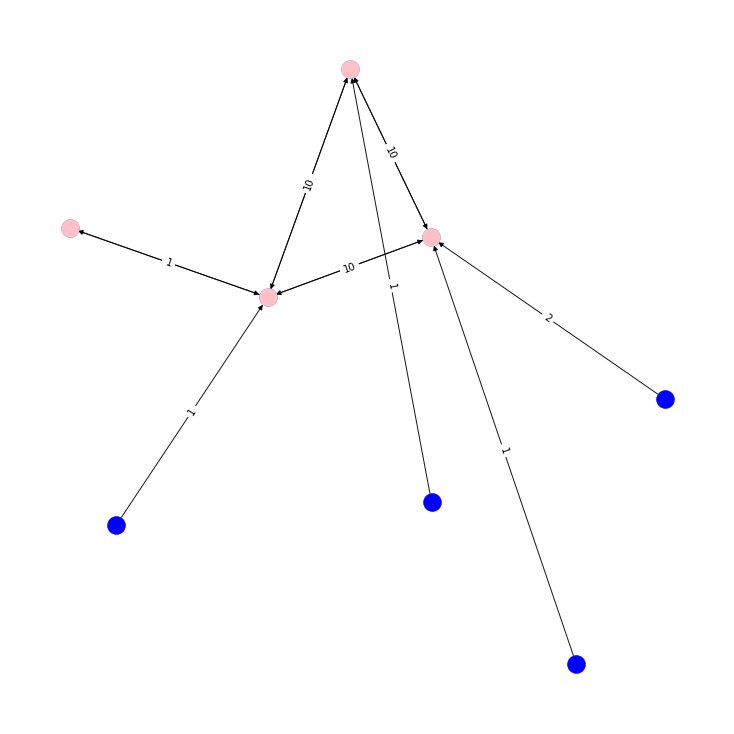

In [98]:
pos = nx.spring_layout(example_graph)
fig = plt.figure(1, figsize=(10, 10))
nx.draw(example_graph, pos = pos, edge_color='black', alpha=0.9,)
nx.draw_networkx_nodes(example_graph, pos=pos, nodelist=l1, node_color='pink')
nx.draw_networkx_nodes(example_graph, pos=pos, nodelist=l2, node_color='blue')
nx.draw_networkx_edge_labels(example_graph, pos = pos, edge_labels=nx.get_edge_attributes(example_graph, 'RATING'))
plt.axis('off')
plt.show()

### 探究包含欺诈群体各类社群与good fair间关系

good/fair 以gmc为例 直方图 (gmc, 65 communities, without settting cutoff)
- good fair分布图 整个网络为整体 个体为单位 两个数据集 12
- good fair 分布图 典型欺诈性社群/信任社群/其他社群为整体 社群内个体为单位 一个数据集 13
- 平均good fair 分布图 整个网络为整体 欺诈性社群/信任社群/其他社群 为单位 一个数据集 13 先不弄了


#### Preparation

In [190]:
iaws, eaws, diffs, cheatings, commons = analyze_communities(coms=coms_gmc, threshold=5, return_commons=True)

In [139]:
# import pickle
# with open('fairness_of_nodes.pickle', 'rb') as handle:
#     fairness = pickle.load(handle)

# with open('goodness_of_nodes.pickle', 'rb') as handle:
#     goodness = pickle.load(handle)

import pickle
with open('fairness_of_nodes(1).pickle', 'rb') as handle:
    fairness = pickle.load(handle)

with open('goodness_of_nodes(1).pickle', 'rb') as handle:
    goodness = pickle.load(handle)

import pickle
with open('fairness_of_nodes_otc.pickle', 'rb') as handle:
    fairness_otc = pickle.load(handle)

with open('goodness_of_nodes_otc.pickle', 'rb') as handle:
    goodness_otc = pickle.load(handle)

In [123]:
max(fairness.values()), min(fairness.values())

(0.9999999999999999, 0.35135923922144374)

In [124]:
max(goodness.values()), min(goodness.values())

(0.9937442766341512, -0.99951171875)

#### good fair分布图 整个网络为整体 个体为单位 两个数据集 12

In [ ]:
# degrees = [g.degree(i) for i in g.nodes()]
# my_bins = np.logspace(np.log10(min(degrees)),np.log10(max(degrees) +1), 30 ) 
# _ = plt.hist(degrees, bins = my_bins,density = True)
# plt.xscale('log')
# plt.yscale('log')
# plt.title("degree distribution")
# plt.xlabel('degree')
# plt.ylabel('count density (log)')

In [143]:
import scipy.stats as stats

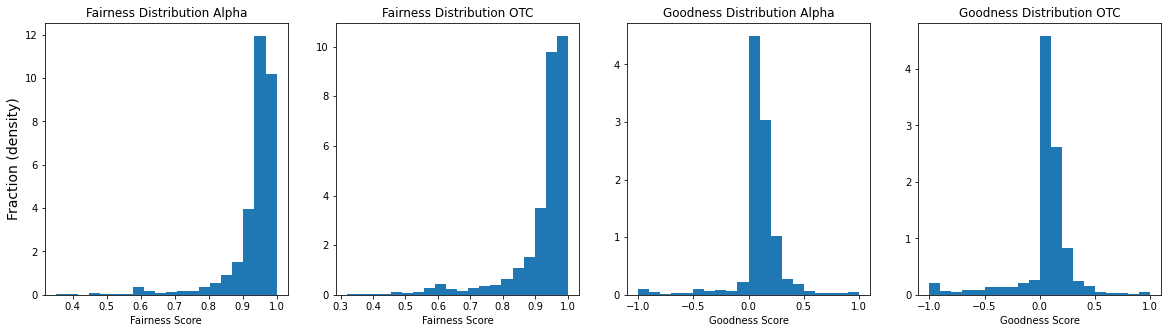

In [296]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
# fig.suptitle('Horizontally stacked subplots')
# axs[0, 0].set_title('Axis [0, 0]')
# ax.set(xlabel='x-label', ylabel='y-label')
# fig.set_size_inches(18.5, 10.5)
axs[0].hist(fairness.values(), bins = 20, density=True)
# axs[0].plot(spacing_f, fairness.values(), )
axs[0].set_title("Fairness Distribution Alpha")
axs[0].set_xlabel("Fairness Score")
axs[0].set_ylabel("Fraction (density)", fontsize=14)
axs[1].hist(fairness_otc.values(), bins = 20, density=True)
axs[1].set_title("Fairness Distribution OTC")
axs[1].set_xlabel("Fairness Score")

axs[2].hist(goodness.values(), bins = 20, range=(-1,1),  density=True)
axs[2].set_title("Goodness Distribution Alpha")
axs[2].set_xlabel("Goodness Score")
axs[3].hist(goodness_otc.values(), bins = 20, range=(-1,1),  density=True)
axs[3].set_title("Goodness Distribution OTC")
axs[3].set_xlabel("Goodness Score")
plt.show()
fig.savefig('images/group2/fg distribution')

#### good fair 分布图 典型欺诈性社群/信任社群/其他社群为整体 社群内个体为单位 一个数据集 13

In [194]:
ch = cheatings[0]
co = commons[0]

In [185]:
fair_cheating = []
good_cheating = []
for node in ch:
    if node in fairness.keys():
        fair_cheating.append(fairness[node])
    if node in goodness.keys():
        good_cheating.append(goodness[node])

fair_cheating, good_cheating

([0.5324904036648634,
  0.47539953132101276,
  0.7360286555599701,
  0.7621494454177806,
  0.5580209272050543],
 [-0.20976973910005026,
  -0.5024483962534055,
  -0.36546470722410346,
  -0.09794627394229659,
  -0.32392274668047694,
  -0.28396133329216594,
  -0.29817677155765465,
  -0.24611563866006927])

In [195]:
fair_common = []
good_common = []
for node in co:
    if node in fairness.keys():
        fair_common.append(fairness[node])
    if node in goodness.keys():
        good_common.append(goodness[node])

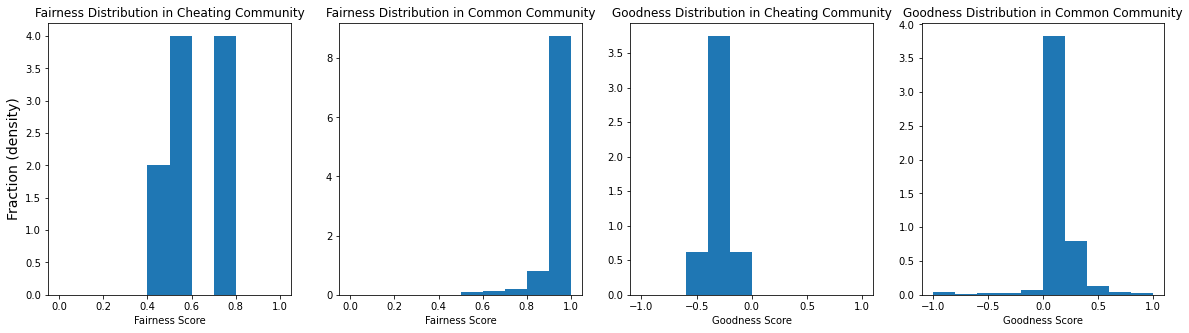

In [298]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
# fig.suptitle('Horizontally stacked subplots')
# axs[0, 0].set_title('Axis [0, 0]')
# ax.set(xlabel='x-label', ylabel='y-label')
# fig.set_size_inches(18.5, 10.5)
axs[0].hist(fair_cheating, range=(0,1), density=True)
# axs[0].plot(spacing_f, fairness.values(), )
axs[0].set_title("Fairness Distribution in Cheating Community")
axs[0].set_xlabel("Fairness Score")
axs[0].set_ylabel("Fraction (density)", fontsize=14)

axs[1].hist(fair_common, range=(0,1), density=True)
axs[1].set_title("Fairness Distribution in Common Community")
axs[1].set_xlabel("Fairness Score")

axs[2].hist(good_cheating, range=(-1,1),  density=True)
axs[2].set_title("Goodness Distribution in Cheating Community")
axs[2].set_xlabel("Goodness Score")
axs[3].hist(good_common, range=(-1,1),  density=True)
axs[3].set_title("Goodness Distribution in Common Community")
axs[3].set_xlabel("Goodness Score")
plt.show()
fig.savefig('images/group2/fg ch vs co distribution')

### 探究社群划分数量与大小 与diffs的关系
diffs 
algorithm, number, score difference, strong connected, multiple datasets, avg fog, community size

折线图
gmc，flu 横排 community number 纵向 diffs判定为cheating，信赖，普通的百分比 两个数据集 1 4 没法画

点云图
四种算法 横轴 community size 纵轴 diffs （可能平均fog）1 4 一个或两个数据集

In [221]:
avg_gmc = []
for cutoff in [100, 150, 200, 250, 300]:
    print(cutoff)
    coms_gmc = list(nxcom.greedy_modularity_communities(G, cutoff=cutoff)) #cut off
    print(len(coms_gmc))
    iaws, eaws, diffs, cheatings, commons = analyze_communities(coms=coms_gmc, threshold=5, return_commons=True)
    data = [[],[],[]]
    avgs = []
    for diff in diffs:
        if diff >= 10:
            data[0].append(diff)
        elif diff >= 5:
            data[1].append(diff)
        else:
            data[2].append(diff)
    avgs.append(len(data[0])/len(diffs))
    avgs.append(len(data[1])/len(diffs))
    avgs.append(len(data[2])/len(diffs))
    avg_gmc.append(avgs)
    
    

100
100
150
150
200
200
250
250
300
300


In [222]:
avg_gmc_otc = []
for cutoff in [100, 150, 200, 250, 300]:
    print(cutoff)
    coms_gmc = list(nxcom.greedy_modularity_communities(G_otc, cutoff=cutoff)) #cut off
    print(len(coms_gmc))
    iaws, eaws, diffs, cheatings, commons = analyze_communities(coms=coms_gmc, threshold=5, return_commons=True)
    data = [[],[],[]]
    avgs = []
    for diff in diffs:
        if diff >= 10:
            data[0].append(diff)
        elif diff >= 5:
            data[1].append(diff)
        else:
            data[2].append(diff)
    avgs.append(len(data[0])/len(diffs))
    avgs.append(len(data[1])/len(diffs))
    avgs.append(len(data[2])/len(diffs))
    avg_gmc_otc.append(avgs)

100
100
150
150
200
200
250
250
300
300


In [223]:
avg_gmc, avg_gmc_otc

([[0.03896103896103896, 0.06493506493506493, 0.8961038961038961],
  [0.0379746835443038, 0.06329113924050633, 0.8987341772151899],
  [0.0379746835443038, 0.06329113924050633, 0.8987341772151899],
  [0.0379746835443038, 0.06329113924050633, 0.8987341772151899],
  [0.0375, 0.0625, 0.9]],
 [[0.0, 0.0, 1.0],
  [0.0, 0.0, 1.0],
  [0.0, 0.0, 1.0],
  [0.0, 0.0, 1.0],
  [0.0, 0.0, 1.0]])

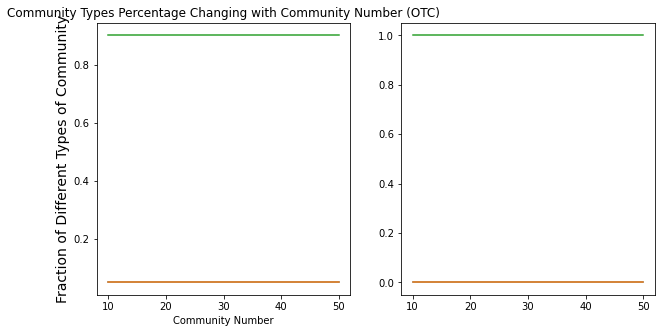

In [213]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# fig.suptitle('Horizontally stacked subplots')
# axs[0, 0].set_title('Axis [0, 0]')
# ax.set(xlabel='x-label', ylabel='y-label')
# fig.set_size_inches(18.5, 10.5)
avg_gmc = np.array(avg_gmc)
avg_gmc_otc = np.array(avg_gmc_otc)
r = [100, 150, 200, 250, 300]
axs[0].plot(r, avg_gmc[:, 0])
axs[0].plot(r, avg_gmc[:, 1])
axs[0].plot(r, avg_gmc[:, 2])
# axs[0].plot(spacing_f, fairness.values(), )
axs[0].set_title("Community Types Percentage Changing with Community Number (Alpha)")
axs[0].set_xlabel("Community Number")
axs[0].set_ylabel("Fraction of Different Types of Community", fontsize=14)

axs[1].plot(r, avg_gmc_otc[:, 0])
axs[1].plot(r, avg_gmc_otc[:, 1])
axs[1].plot(r, avg_gmc_otc[:, 2])
axs[0].set_title("Community Types Percentage Changing with Community Number (OTC)")
axs[0].set_xlabel("Community Number")
axs[0].set_ylabel("Fraction of Different Types of Community", fontsize=14)

plt.show()
fig.savefig('images/group2/fg ch vs co distribution')

In [203]:
# avg_flu = []
# for cutoff in [10, 20, 30, 40, 50]:
#     print(cutoff)
#     coms_gmc = list(nxcom.greedy_modularity_communities(G, cutoff=cutoff)) #cut off
#     iaws, eaws, diffs, cheatings, commons = analyze_communities(coms=coms, threshold=5, return_commons=True)
#     data = [[],[],[]]
#     avgs = []
#     for diff in diffs:
#         if diff >= 10:
#             data[0].append(diff)
#         elif diff >= 5:
#             data[1].append(diff)
#         else:
#             data[2].append(diff)
#     avgs.append(len(data[0])/len(diffs))
#     avgs.append(len(data[1])/len(diffs))
#     avgs.append(len(data[2])/len(diffs))
#     avg_flu.append(avgs)

In [204]:
# avg_gmc, avg_flu


([[0.04918032786885246, 0.04918032786885246, 0.9016393442622951],
  [0.04918032786885246, 0.04918032786885246, 0.9016393442622951],
  [0.04918032786885246, 0.04918032786885246, 0.9016393442622951],
  [0.04918032786885246, 0.04918032786885246, 0.9016393442622951],
  [0.04918032786885246, 0.04918032786885246, 0.9016393442622951]],
 [[0.0, 0.0, 1.0],
  [0.0, 0.0, 1.0],
  [0.0, 0.0, 1.0],
  [0.0, 0.005208333333333333, 0.9947916666666666]])

#### 四种算法 横轴 community size 纵轴 diffs （可能平均fog）1 4 一个或两个数据集

In [226]:
# 4 algorithms
coms_gmc = list(nxcom.greedy_modularity_communities(G)) #cut off

# coms_gmc, coms_lpc, coms_fluidc[-1], coms_k_clique[0]

In [285]:
def cal_x_y(coms_all):
    iaws, eaws, diffs, cheatings = analyze_communities(coms=coms_all)
    x, y = [], []
    for coms, diff in zip(coms_all, diffs):
        x.append(len(coms))
        y.append(diff)
    return np.array(x), np.array(y), diffs

In [286]:
coms_alls = [coms_gmc, coms_lpc, coms_fluidc[-1], coms_k_clique[0]]    
xs, ys = [], []
diffss = []

for coms_all in coms_alls:

    x, y, diffs = cal_x_y(coms_all)
    xs.append(x)
    ys.append(y)
    diffss.append(diffs)

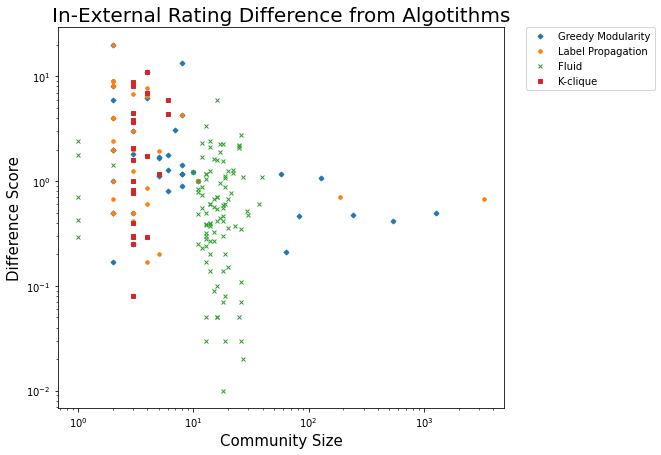

In [283]:
fig, ax = plt.subplots(figsize=(8,7))
symbols = ['D', 'o', 'x', 's']
legends = ['Greedy Modularity', 'Label Propagation', 'Fluid', 'K-clique']
for i in range(len(xs)):
    ax.plot(xs[i], ys[i], symbols[i], markersize = 3.5, label=legends[i])
    ax.set_xscale('log')
    ax.set_yscale('log')
ax.set_title("In-External Rating Difference from Algotithms", fontsize=20)
ax.set_xlabel("Community Size", fontsize=15)
ax.set_ylabel("Difference Score", fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.savefig('images/group2/In-External Difference.jpg')

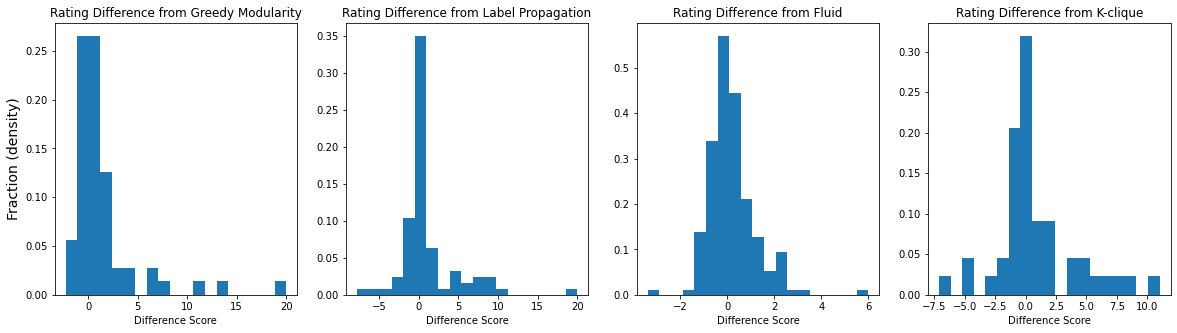

In [297]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
# fig.suptitle('Horizontally stacked subplots')
# axs[0, 0].set_title('Axis [0, 0]')
# ax.set(xlabel='x-label', ylabel='y-label')
# fig.set_size_inches(18.5, 10.5)
axs[0].hist(diffss[0], bins=int(max(diffss[0])-1), density=True)
# axs[0].plot(spacing_f, fairness.values(), )
axs[0].set_title("Rating Difference from Greedy Modularity")
axs[0].set_xlabel("Difference Score")
axs[0].set_ylabel("Fraction (density)", fontsize=14)
axs[1].hist(diffss[1], bins=int(max(diffss[0])-1), density=True)
axs[1].set_title("Rating Difference from Label Propagation")
axs[1].set_xlabel("Difference Score")

axs[2].hist(diffss[2], bins=int(max(diffss[0])-1), density=True)
axs[2].set_title("Rating Difference from Fluid")
axs[2].set_xlabel("Difference Score")
axs[3].hist(diffss[3], bins=int(max(diffss[0])-1), density=True)
axs[3].set_title("Rating Difference from K-clique")
axs[3].set_xlabel("Difference Score")
plt.show()
fig.savefig('images/group2/diff distribution')

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
# fig.suptitle('Horizontally stacked subplots')
# axs[0, 0].set_title('Axis [0, 0]')
# ax.set(xlabel='x-label', ylabel='y-label')
# fig.set_size_inches(18.5, 10.5)

axs[0].plot(r, avg_gmc[:, 0])
axs[0].plot(r, avg_gmc[:, 1])
axs[0].plot(r, avg_gmc[:, 2])
# axs[0].plot(spacing_f, fairness.values(), )
axs[0].set_title("Community Types Percentage Changing with Community Number (Alpha)")
axs[0].set_xlabel("Community Number")
axs[0].set_ylabel("Fraction of Different Types of Community", fontsize=14)

axs[1].plot(r, avg_gmc_otc[:, 0])
axs[1].plot(r, avg_gmc_otc[:, 1])
axs[1].plot(r, avg_gmc_otc[:, 2])
axs[0].set_title("Community Types Percentage Changing with Community Number (OTC)")
axs[0].set_xlabel("Community Number")
axs[0].set_ylabel("Fraction of Different Types of Community", fontsize=14)

plt.show()
fig.savefig('images/group2/fg ch vs co distribution')